## Model Distillation Notebook

In [58]:
import pandas as pd
import numpy as np
from tabpfn import TabPFNRegressor, TabPFNClassifier
import torch
regressor_model = TabPFNRegressor()
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error, root_mean_squared_error
from tabpfn.model_loading import (
    load_fitted_tabpfn_model,
    save_fitted_tabpfn_model,
)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


### Train-test split for both regression and classification Tasks

In [54]:
# Load the loan data (uncomment and fix the data loading)
loan_data = pd.read_csv('../data/loan_data_with_max_loan.csv')
targets = ['loan_status', 'max_loan']

# For classification: predict loan_status using all features except targets
X_class = loan_data.drop(columns=targets)
y_class = loan_data['loan_status']

# For regression: predict max_loan using all features except targets AND loan_status
# (loan_status should not be a feature for regression as it's what we're trying to predict first)
X_reg = loan_data.drop(columns=targets)
y_reg = loan_data['max_loan']

print(f"Classification dataset shape: {X_class.shape}")
print(f"Regression dataset shape: {X_reg.shape}")
print(f"Memory usage: {X_class.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Limit dataset size if too large (TabPFN works best with ≤10K samples)
if X_class.shape[0] > 10000:
    print(f"Dataset too large ({X_class.shape[0]} samples). Sampling 10,000 rows...")
    from sklearn.utils import resample
    X_class_sample, y_class_sample = resample(X_class, y_class, n_samples=10000, random_state=42, stratify=y_class)
    X_reg_sample, y_reg_sample = resample(X_reg, y_reg, n_samples=10000, random_state=42)
    
    X_class, y_class = X_class_sample, y_class_sample
    X_reg, y_reg = X_reg_sample, y_reg_sample
    print(f"New dataset shape: {X_class.shape}")

# Create train/test splits for both tasks using the same features
X_train, X_test, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Classification dataset shape: (48842, 14)
Regression dataset shape: (48842, 14)
Memory usage: 26.79 MB
Dataset too large (48842 samples). Sampling 10,000 rows...
New dataset shape: (10000, 14)


### Model fit with teacher model - TabPFN and assess accuracy

- **Classification**

In [55]:
## Classification with TabPFNClassifier

# Initialize classifier with memory-saving options
clf = TabPFNClassifier(
    device="cpu",  # Use CPU to avoid GPU memory issues
    memory_saving_mode=True,  # Enable memory saving
    n_estimators=2,  # Reduce ensemble size to save memory
    ignore_pretraining_limits=True
)

print("Fitting the model...")
clf.fit(X_train, y_train_class)
save_fitted_tabpfn_model(clf, "../artefacts/teacher_classifier.tabpfn_fit")

# Predict in smaller batches to avoid memory issues
print("Making predictions...")
batch_size = 1000
n_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

prediction_probabilities = []
predictions = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    
    X_batch = X_test.iloc[start_idx:end_idx]
    
    # Predict probabilities for batch
    batch_proba = clf.predict_proba(X_batch)
    prediction_probabilities.append(batch_proba)
    
    # Predict labels for batch
    batch_pred = clf.predict(X_batch)
    predictions.append(batch_pred)
    
    print(f"Processed batch {i+1}/{n_batches}")

# Combine results
prediction_probabilities = np.vstack(prediction_probabilities)
predictions = np.concatenate(predictions)

print("ROC AUC:", roc_auc_score(y_test_class, prediction_probabilities[:, 1]))
print("Accuracy:", accuracy_score(y_test_class, predictions))

Fitting the model...
Making predictions...
Making predictions...
Processed batch 1/2
Processed batch 1/2
Processed batch 2/2
ROC AUC: 0.919376999026561
Accuracy: 0.8555
Processed batch 2/2
ROC AUC: 0.919376999026561
Accuracy: 0.8555


- **Regression**

In [ ]:
## Regression with TabPFNRegressor

Initialize regressor with memory-saving options
reg = TabPFNRegressor(
    device="cpu",  # Use CPU to avoid GPU memory issues
    memory_saving_mode=True,  # Enable memory saving
    n_estimators=2,  # Reduce ensemble size to save memory
    ignore_pretraining_limits=True
)

print("Fitting the regression model...")
reg.fit(X_train, y_train_reg)
save_fitted_tabpfn_model(reg, "../artefacts/teacher_regressor.tabpfn_fit")

# Predict in smaller batches to avoid memory issues
print("Making regression predictions with conditional logic...")
batch_size = 1000
n_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

regression_predictions = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    
    X_batch = X_test.iloc[start_idx:end_idx]
    
    # Get classification probabilities first
    batch_class_proba = clf.predict_proba(X_batch)
    class_prob_positive = batch_class_proba[:, 1]  # Probability of loan approval
    
    # Get regression predictions
    batch_reg_pred = reg.predict(X_batch)
    
    # Apply conditional logic: if classification probability < 0.5, set loan amount to 0
    conditional_predictions = np.where(class_prob_positive >= 0.5, batch_reg_pred, 0)
    regression_predictions.append(conditional_predictions)
    
    print(f"Processed batch {i+1}/{n_batches}")
    print(f"  Approved loans in batch: {np.sum(class_prob_positive >= 0.5)}/{len(class_prob_positive)}")

# Combine results
final_regression_predictions = np.concatenate(regression_predictions)

# Evaluate the model
rmse = root_mean_squared_error(y_test_reg, final_regression_predictions)
r2 = r2_score(y_test_reg, final_regression_predictions)

print(f"\nRegression Results with Conditional Logic:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Additional analysis
approved_mask = final_regression_predictions > 0
print(f"\nConditional Prediction Analysis:")
print(f"Total test samples: {len(y_test_reg)}")
print(f"Predicted approvals: {np.sum(approved_mask)}")
print(f"Actual approvals (y > 0): {np.sum(y_test_reg > 0)}")
if np.sum(approved_mask) > 0:
    rmse_approved = root_mean_squared_error(y_test_reg[approved_mask], final_regression_predictions[approved_mask])
    print(f"RMSE for approved loans only: {rmse_approved:.2f}")
    r2_approved = r2_score(y_test_reg[approved_mask], final_regression_predictions[approved_mask])
    print(f"R² Score for approved loans only: {r2_approved:.4f}")


Regression Results with Conditional Logic:
Root Mean Squared Error (RMSE): 12184958976.00
R² Score: -0.2475

Conditional Prediction Analysis:
Total test samples: 2000
Predicted approvals: 377
Actual approvals (y > 0): 502
RMSE for approved loans only: 96897.74
R² Score for approved loans only: -0.0059


- **Ensuring Reproducibility**

In [ ]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # slower, but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)

### DataLoader for both regression and classification Tasks

In [61]:
# Create DataLoader for training with both classification and regression targets

# Identify categorical and numerical columns
print("Identifying feature types...")
print(f"Dataset columns: {list(X_train.columns)}")
print(f"Dataset dtypes:\n{X_train.dtypes}")

# Separate categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Fit and transform the data
print("\nPreprocessing features...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Original feature count: {X_train.shape[1]}")
print(f"Processed feature count: {X_train_processed.shape[1]}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_class_tensor = torch.LongTensor(y_train_class.values)
y_train_reg_tensor = torch.FloatTensor(y_train_reg.values)

X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_class_tensor = torch.LongTensor(y_test_class.values)
y_test_reg_tensor = torch.FloatTensor(y_test_reg.values)

print(f"\nTensor shapes:")
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train_class: {y_train_class_tensor.shape}")
print(f"y_train_reg: {y_train_reg_tensor.shape}")

# Create combined dataset with both targets
train_dataset = TensorDataset(X_train_tensor, y_train_class_tensor, y_train_reg_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_class_tensor, y_test_reg_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader Info:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Final feature count: {X_train_tensor.shape[1]}")

# Store preprocessor for later use
feature_preprocessor = preprocessor

Identifying feature types...
Dataset columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Dataset dtypes:
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Preprocessing features...
Original feature count: 14
Processed feature count: 97

Tensor shapes:
X_train: torch.Size([8000, 97])
y_train_

/Users/sourishdey/Desktop/learning/model_distillation/model_distillation/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


- **Pre-compute teacher predictions for efficient training**

In [ ]:
print("Pre-computing teacher predictions with conditional logic...")
print("=" * 50)

# Get teacher predictions for training data
print("Getting classifier predictions...")
teacher_class_probs_train = clf.predict_proba(X_train)
teacher_class_logits_train = np.log(teacher_class_probs_train + 1e-8)

print("Getting regressor predictions with conditional logic...")
# Get raw regression predictions
teacher_reg_raw_preds_train = reg.predict(X_train)
# Apply conditional logic: if classification probability < 0.5, set loan amount to 0
class_prob_positive_train = teacher_class_probs_train[:, 1]
teacher_reg_preds_train = np.where(class_prob_positive_train >= 0.5, teacher_reg_raw_preds_train, 0)

print("Getting test predictions for evaluation...")
teacher_class_probs_test = clf.predict_proba(X_test)
teacher_reg_raw_preds_test = reg.predict(X_test)
class_prob_positive_test = teacher_class_probs_test[:, 1]
teacher_reg_preds_test = np.where(class_prob_positive_test >= 0.5, teacher_reg_raw_preds_test, 0)

# Convert to tensors and store
teacher_class_logits_tensor = torch.FloatTensor(teacher_class_logits_train)
teacher_reg_preds_tensor = torch.FloatTensor(teacher_reg_preds_train).view(-1, 1)

print(f"Teacher predictions computed with conditional logic:")
print(f"  Classification logits shape: {teacher_class_logits_tensor.shape}")
print(f"  Regression predictions shape: {teacher_reg_preds_tensor.shape}")
print(f"  Training samples with approval (prob >= 0.5): {np.sum(class_prob_positive_train >= 0.5)}/{len(class_prob_positive_train)}")
print(f"  Training samples with non-zero loan amounts: {np.sum(teacher_reg_preds_train > 0)}/{len(teacher_reg_preds_train)}")

# Create new dataset with teacher predictions included
train_dataset_with_teachers = TensorDataset(
    X_train_tensor, 
    y_train_class_tensor, 
    y_train_reg_tensor,
    teacher_class_logits_tensor,
    teacher_reg_preds_tensor
)

train_loader_with_teachers = DataLoader(train_dataset_with_teachers, batch_size=batch_size, shuffle=True)

print(f"Enhanced training loader created with {len(train_loader_with_teachers)} batches")

Pre-computing teacher predictions with conditional logic...
Getting classifier predictions...
Getting regressor predictions with conditional logic...
Getting regressor predictions with conditional logic...
Getting test predictions for evaluation...
Getting test predictions for evaluation...
Teacher predictions computed with conditional logic:
  Classification logits shape: torch.Size([8000, 2])
  Regression predictions shape: torch.Size([8000, 1])
  Training samples with approval (prob >= 0.5): 1618/8000
  Training samples with non-zero loan amounts: 1618/8000
Enhanced training loader created with 125 batches
Teacher predictions computed with conditional logic:
  Classification logits shape: torch.Size([8000, 2])
  Regression predictions shape: torch.Size([8000, 1])
  Training samples with approval (prob >= 0.5): 1618/8000
  Training samples with non-zero loan amounts: 1618/8000
Enhanced training loader created with 125 batches


- **PyTorch based Student model Classes**

In [63]:
# Student binary classification model for tabular data

class SmallClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)          # Second hidden layer
        self.fc3 = nn.Linear(32, 2)           # Output layer (2 classes for binary classification)
        self.dropout = nn.Dropout(0.2)        # Dropout for regularization
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))  
        x = self.dropout(x)
        return self.fc3(x)  # Raw logits for CrossEntropyLoss

# Student regression model for tabular data

class SmallRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)          # Second hidden layer
        self.fc3 = nn.Linear(32, 1)           # Output layer (1 output for regression)
        self.dropout = nn.Dropout(0.2)        # Dropout for regularization
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))     
        x = self.dropout(x)
        return self.fc3(x)  # Linear output for regression   

# Instantiate models with correct input size after preprocessing
# Note: This cell should be run AFTER the preprocessing cell
print(f"Creating student models with input size: {X_train_tensor.shape[1]}")

student_classifier_model = SmallClassifier(input_size=X_train_tensor.shape[1]).to(device)   
student_regressor_model = SmallRegressor(input_size=X_train_tensor.shape[1]).to(device)

print("Student models created successfully!")
print(f"Classifier parameters: {sum(p.numel() for p in student_classifier_model.parameters()):,}")
print(f"Regressor parameters: {sum(p.numel() for p in student_regressor_model.parameters()):,}")

Creating student models with input size: 97
Student models created successfully!
Classifier parameters: 8,418
Regressor parameters: 8,385


### Distillation Loss Functions

- **The student model is trained not just to replicate the final predictions of the teacher model but to align its output distributions (soft targets) with those of the teacher.**
- **These soft targets contain more detailed information about the model’s predictions than hard labels (the final class predictions), providing insights into the confidence levels of the teacher model across various classes.**
- **So the Total Knowledge Distillation Loss will be**

- **For a Classification Task context**

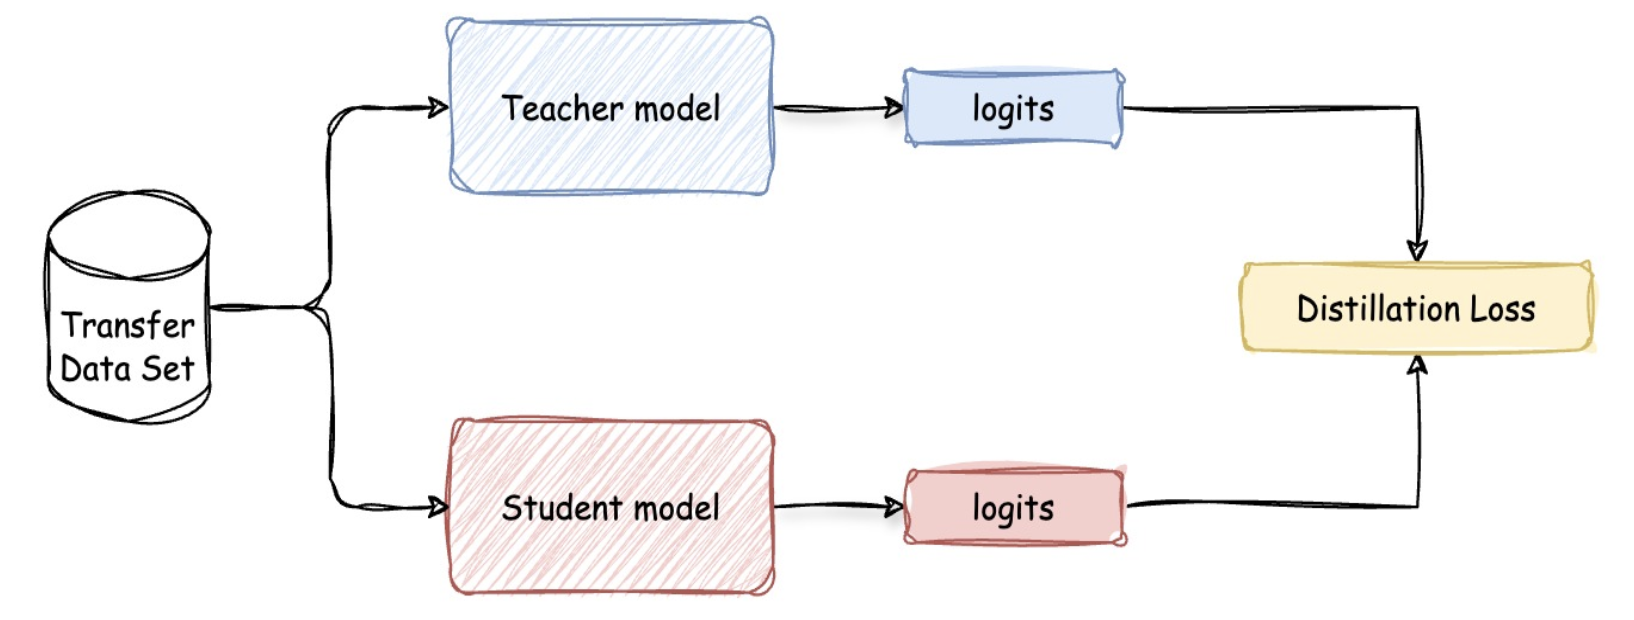

                                        Distillation Loss = Hard Loss + Soft Loss

In [64]:
# Distillation loss function for classification
def distillation_loss_classification(student_logits, teacher_logits, labels, T=2.0, alpha=0.7):
    """
    Knowledge distillation loss for classification tasks.
    
    Args:
        student_logits: Raw outputs from student model
        teacher_logits: Raw outputs from teacher model  
        labels: True labels
        T: Temperature for softening probability distributions
        alpha: Weight for soft loss vs hard loss
    """
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Distillation loss function for regression
def distillation_loss_regression(student_outputs, teacher_outputs, labels, T=1.0, alpha=0.7):
    """
    Knowledge distillation loss for regression tasks.
    
    Args:
        student_outputs: Predictions from student model
        teacher_outputs: Predictions from teacher model
        labels: True target values
        T: Temperature scaling factor (less critical for regression)
        alpha: Weight for soft loss vs hard loss
    """
    # Soft loss: MSE between student and teacher predictions (knowledge transfer)
    soft_loss = F.mse_loss(student_outputs / T, teacher_outputs / T)
    
    # Hard loss: MSE between student predictions and true labels (accuracy)
    hard_loss = F.mse_loss(student_outputs, labels)
    
    return alpha * soft_loss + (1 - alpha) * hard_loss

- **Student Model Training**

In [ ]:
# Distill Knowledge to Student Models

def train_student_efficient(student_classifier_model, student_regressor_model, train_loader_with_teachers, T=2.0, alpha=0.7, epochs=10):
    """
    Train student models using pre-computed teacher predictions.
    
    Args:
        student_classifier_model: Student neural network for classification
        student_regressor_model: Student neural network for regression  
        train_loader_with_teachers: DataLoader with (X, y_class, y_reg, teacher_class_logits, teacher_reg_preds)
        T: Temperature for distillation
        alpha: Weight for soft vs hard loss
        epochs: Number of training epochs
    """
    # Set models to training mode
    student_classifier_model.train()
    student_regressor_model.train()
    
    # Create optimizers
    optimizer_class = optim.Adam(student_classifier_model.parameters(), lr=0.001)
    optimizer_reg = optim.Adam(student_regressor_model.parameters(), lr=0.001)

    for epoch in range(epochs):
        total_loss_class = 0
        total_loss_reg = 0
        num_batches = 0
        
        for batch_data in train_loader_with_teachers:
            x, y_class, y_reg, teacher_class_logits, teacher_reg_preds = batch_data
            
            # Move to device
            x = x.to(device)
            y_class = y_class.to(device)
            y_reg = y_reg.to(device)
            teacher_class_logits = teacher_class_logits.to(device)
            teacher_reg_preds = teacher_reg_preds.to(device)

            # Get student predictions
            student_class_outputs = student_classifier_model(x)
            student_reg_outputs = student_regressor_model(x)
            
            # Calculate distillation losses using pre-computed teacher predictions
            loss_class = distillation_loss_classification(student_class_outputs, teacher_class_logits, y_class, T, alpha)
            loss_reg = distillation_loss_regression(student_reg_outputs, teacher_reg_preds, y_reg.view(-1, 1), T, alpha)

            # Backward pass and optimization for classification
            optimizer_class.zero_grad()
            loss_class.backward()
            optimizer_class.step()
            
            # Backward pass and optimization for regression
            optimizer_reg.zero_grad()
            loss_reg.backward()
            optimizer_reg.step()
            
            total_loss_class += loss_class.item()
            total_loss_reg += loss_reg.item()
            num_batches += 1
            
        # Print epoch statistics
        avg_loss_class = total_loss_class / num_batches
        avg_loss_reg = total_loss_reg / num_batches
        total_loss = avg_loss_class + avg_loss_reg
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Classification Loss: {avg_loss_class:.4f}")
        print(f"  Regression Loss: {avg_loss_reg:.4f}")
        print(f"  Total Loss: {total_loss:.4f}")
        print("-" * 40)

- **Training Iterations**

In [65]:
# Train student models with knowledge distillation
print("Starting efficient knowledge distillation training...")
print("=" * 50)

train_student_efficient(
    student_classifier_model=student_classifier_model,
    student_regressor_model=student_regressor_model,
    train_loader_with_teachers=train_loader_with_teachers,
    T=2.0,
    alpha=0.7,
    epochs=10
)

print("\nKnowledge distillation training completed!")   

Starting efficient knowledge distillation training...
Epoch 1/10:
  Classification Loss: 0.4852
  Regression Loss: 3760484572.1600
  Total Loss: 3760484572.6452
----------------------------------------
Epoch 2/10:
  Classification Loss: 0.1981
  Regression Loss: 3749864875.0080
  Total Loss: 3749864875.2061
----------------------------------------
Epoch 3/10:
  Classification Loss: 0.1707
  Regression Loss: 3701324301.3120
  Total Loss: 3701324301.4827
----------------------------------------
Epoch 2/10:
  Classification Loss: 0.1981
  Regression Loss: 3749864875.0080
  Total Loss: 3749864875.2061
----------------------------------------
Epoch 3/10:
  Classification Loss: 0.1707
  Regression Loss: 3701324301.3120
  Total Loss: 3701324301.4827
----------------------------------------
Epoch 4/10:
  Classification Loss: 0.1524
  Regression Loss: 3597461108.7360
  Total Loss: 3597461108.8884
----------------------------------------
Epoch 5/10:
  Classification Loss: 0.1461
  Regression Los

- **Evaluation Student Models**

In [67]:
# Evaluate Student Models Performance with Conditional Logic

def evaluate_student_models(student_classifier, student_regressor, test_loader):
    """
    Evaluate the performance of trained student models with conditional regression logic.
    """
    student_classifier.eval()
    student_regressor.eval()
    
    all_class_preds = []
    all_class_probs = []
    all_class_targets = []
    all_reg_preds = []
    all_reg_targets = []
    all_conditional_reg_preds = []
    
    with torch.no_grad():
        for batch_data in test_loader:
            x, y_class, y_reg = batch_data
            x = x.to(device)
            
            # Classification predictions
            class_outputs = student_classifier(x)
            class_probs = F.softmax(class_outputs, dim=1)
            class_preds = torch.argmax(class_outputs, dim=1)
            
            # Regression predictions
            reg_outputs = student_regressor(x)
            
            # Apply conditional logic for regression: if classification prob < 0.5, set loan to 0
            class_prob_positive = class_probs[:, 1].cpu().numpy()  # Probability of approval
            raw_reg_preds = reg_outputs.cpu().numpy().flatten()
            conditional_reg_preds = np.where(class_prob_positive >= 0.5, raw_reg_preds, 0)
            
            # Collect predictions
            all_class_preds.extend(class_preds.cpu().numpy())
            all_class_probs.extend(class_prob_positive)
            all_class_targets.extend(y_class.numpy())
            all_reg_preds.extend(raw_reg_preds)  # Raw regression predictions
            all_conditional_reg_preds.extend(conditional_reg_preds)  # Conditional predictions
            all_reg_targets.extend(y_reg.numpy())
    
    # Calculate classification metrics
    class_accuracy = accuracy_score(all_class_targets, all_class_preds)
    class_auc = roc_auc_score(all_class_targets, all_class_probs)
    
    # Calculate regression metrics (raw predictions)
    reg_rmse_raw = root_mean_squared_error(all_reg_targets, all_reg_preds)
    reg_r2_raw = r2_score(all_reg_targets, all_reg_preds)
    
    # Calculate regression metrics (conditional predictions)
    reg_rmse_conditional = root_mean_squared_error(all_reg_targets, all_conditional_reg_preds)
    reg_r2_conditional = r2_score(all_reg_targets, all_conditional_reg_preds)
    
    # Additional analysis for approved loans only
    approved_mask = np.array(all_conditional_reg_preds) > 0
    approved_count = np.sum(approved_mask)
    
    results = {
        'classification': {
            'accuracy': class_accuracy,
            'auc': class_auc
        },
        'regression_raw': {
            'rmse': reg_rmse_raw,
            'r2': reg_r2_raw
        },
        'regression_conditional': {
            'rmse': reg_rmse_conditional,
            'r2': reg_r2_conditional
        },
        'conditional_analysis': {
            'total_samples': len(all_reg_targets),
            'predicted_approvals': approved_count,
            'actual_positives': np.sum(np.array(all_reg_targets) > 0)
        }
    }
    
    if approved_count > 0:
        approved_targets = np.array(all_reg_targets)[approved_mask]
        approved_preds = np.array(all_conditional_reg_preds)[approved_mask]
        results['conditional_analysis']['mse_approved_only'] = mean_squared_error(approved_targets, approved_preds)
    
    return results

# Evaluate student models
print("\n STUDENT MODEL EVALUATION WITH CONDITIONAL LOGIC")
print("=" * 60)

student_results = evaluate_student_models(student_classifier_model, student_regressor_model, test_loader)

print(" Classification Results:")
print(f"  Accuracy: {student_results['classification']['accuracy']:.4f}")
print(f"  ROC AUC: {student_results['classification']['auc']:.4f}")

print("\n Regression Results (Raw Predictions):")
print(f"  RMSE: {student_results['regression_raw']['rmse']:.2f}")
print(f"  R² Score: {student_results['regression_raw']['r2']:.4f}")

print("\n Regression Results (Conditional Logic - prob >= 0.5):")
print(f"  RMSE: {student_results['regression_conditional']['rmse']:.2f}")
print(f"  R² Score: {student_results['regression_conditional']['r2']:.4f}")

print("\n Conditional Prediction Analysis:")
ca = student_results['conditional_analysis']
print(f"  Total test samples: {ca['total_samples']}")
print(f"  Predicted approvals (student): {ca['predicted_approvals']}")
print(f"  Actual positives (ground truth): {ca['actual_positives']}")
if 'rmse_approved_only' in ca:
    print(f"  RMSE for approved loans only: {ca['rmse_approved_only']:.2f}")

print("\n Model Logic Summary:")
print("• Classification: Predicts loan approval probability")
print("• Regression: Predicts loan amount, but only if classification prob >= 0.5")
print("• If classification prob < 0.5 → loan amount = 0 (rejection)")


 STUDENT MODEL EVALUATION WITH CONDITIONAL LOGIC
 Classification Results:
  Accuracy: 0.8540
  ROC AUC: 0.9140

 Regression Results (Raw Predictions):
  RMSE: 100878.49
  R² Score: -0.0419

 Regression Results (Conditional Logic - prob >= 0.5):
  RMSE: 110418.55
  R² Score: -0.2482

 Conditional Prediction Analysis:
  Total test samples: 2000
  Predicted approvals (student): 362
  Actual positives (ground truth): 502

 Model Logic Summary:
• Classification: Predicts loan approval probability
• Regression: Predicts loan amount, but only if classification prob >= 0.5
• If classification prob < 0.5 → loan amount = 0 (rejection)
